In [1]:
import pandas as pd
import json
import datetime, time
from sklearn.model_selection import train_test_split
import itertools
import os
import zipfile

import numpy as np

import requests
import matplotlib.pyplot as plt

import scipy.sparse as sp
from sklearn.metrics import roc_auc_score


from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Input, Layer
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

# Read data

In [2]:
df_movies = pd.read_csv("data/movies_cast_company.csv", encoding='utf8')
df_movies["cast"] = df_movies["cast"].apply(lambda x: json.loads(x))
df_movies["company"] = df_movies["company"].apply(lambda x: json.loads(x))

# TODO: just temporary, later remove
additional_rows = []#["title"]
df_movies = df_movies.drop(additional_rows+["url"]+list(df_movies.columns[-4:]), axis=1)

print(df_movies.shape)
df_movies.head()

(1315, 22)


,movie_id_ml,title,release,unknown,action,adventure,animation,childrens,comedy,crime,...,fantasy,noir,horror,musical,mystery,romance,scifi,thriller,war,western
0,1,toy story,1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,goldeneye,1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,four rooms,1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,get shorty,1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,copycat,1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [3]:
def string2ts(string, fmt="%Y-%m-%d %H:%M:%S"):
    dt = datetime.datetime.strptime(string, fmt)
    t_tuple = dt.timetuple()
    return int(time.mktime(t_tuple))

In [4]:
df_ratings = pd.read_csv("data/ratings.csv")

# TODO: just temporary, later remove
#additional_rows = ["rating_timestamp"]
df_ratings.rating_timestamp = df_ratings.rating_timestamp.apply(lambda x: string2ts(x))

print(df_ratings.shape)
df_ratings.head()

(100000, 4)


,user_id,movie_id_ml,rating,rating_timestamp
0,196,242,3,881247349
1,186,302,3,891710542
2,22,377,1,878883516
3,244,51,2,880603323
4,166,346,1,886393996


In [5]:
df_users = pd.read_csv("data/users.csv")

# TODO: just temporary, later remove
additional_rows = ["user_zipcode"]
df_users = df_users.drop(additional_rows, axis=1)

num2occupation = dict(enumerate(df_users.user_occupation.unique()))
occupation2num = {y:x for x,y in num2occupation.items()}
num2gender = dict(enumerate(df_users.user_gender.unique()))
gender2num = {y:x for x,y in num2gender.items()}
df_users.user_occupation = df_users.user_occupation.apply(lambda x: occupation2num[x])
df_users.user_gender = df_users.user_gender.apply(lambda x: gender2num[x])


print(df_users.shape)
df_users.head()

(943, 4)


,user_id,user_age,user_gender,user_occupation
0,1,24,0,0
1,2,53,1,1
2,3,23,0,2
3,4,24,0,0
4,5,33,1,1


In [6]:
df = pd.merge(df_movies, df_ratings, on="movie_id_ml")
df = pd.merge(df, df_users, on="user_id")

print(df.shape)
df.head()

(90851, 28)


,movie_id_ml,title,release,unknown,action,adventure,animation,childrens,comedy,crime,...,scifi,thriller,war,western,user_id,rating,rating_timestamp,user_age,user_gender,user_occupation
0,1,toy story,1995,0,0,0,1,1,1,0,...,0,0,0,0,308,4,887732932,60,0,18
1,4,get shorty,1995,0,1,0,0,0,1,0,...,0,0,0,0,308,5,887734290,60,0,18
2,5,copycat,1995,0,0,0,0,0,0,1,...,0,1,0,0,308,4,887736008,60,0,18
3,7,twelve monkeys,1995,0,0,0,0,0,0,0,...,1,0,0,0,308,4,887735247,60,0,18
4,8,babe,1995,0,0,0,0,1,1,0,...,0,0,0,0,308,5,887733096,60,0,18


In [7]:
id2movie = dict(enumerate(df.movie_id_ml.unique()))
movie2id = {y:x for x,y in id2movie.items()}

id2user = dict(enumerate(df.user_id.unique()))
user2id = {y:x for x,y in id2user.items()}

In [8]:
df["iid"] = df.apply(lambda x: movie2id[x.movie_id_ml], axis=1)
df["uid"] = df.apply(lambda x: user2id[x.user_id], axis=1)

In [9]:
df

,movie_id_ml,title,release,unknown,action,adventure,animation,childrens,comedy,crime,...,war,western,user_id,rating,rating_timestamp,user_age,user_gender,user_occupation,iid,uid
0,1,toy story,1995,0,0,0,1,1,1,0,...,0,0,308,4,887732932,60,0,18,0,0
1,4,get shorty,1995,0,1,0,0,0,1,0,...,0,0,308,5,887734290,60,0,18,1,0
2,5,copycat,1995,0,0,0,0,0,0,1,...,0,0,308,4,887736008,60,0,18,2,0
3,7,twelve monkeys,1995,0,0,0,0,0,0,0,...,0,0,308,4,887735247,60,0,18,3,0
4,8,babe,1995,0,0,0,0,1,1,0,...,0,0,308,5,887733096,60,0,18,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90846,748,the saint,1997,0,1,0,0,0,0,0,...,0,0,729,4,893279438,19,0,5,348,942
90847,751,tomorrow never dies,1997,0,1,0,0,0,0,0,...,0,0,729,3,893279138,19,0,5,447,942
90848,879,the peacemaker,1997,0,1,0,0,0,0,0,...,1,0,729,3,893279099,19,0,5,659,942
90849,894,home alone 3,1997,0,0,0,0,1,1,0,...,0,0,729,1,893279311,19,0,5,875,942


In [10]:
# TODO; remove this line when real user
new_user_id = 942 #user_movie_ratings_training[0][0]
df = df[df.uid != new_user_id]

In [11]:
df = df.drop_duplicates()

In [12]:
# shape [n_users, n_user_features]
df_users = df[["uid", "user_age", "user_gender", "user_occupation"]].drop_duplicates()
print(f"Number of users features: {df_users.shape[0]}")

df_movies = df[["iid"]+list(df.columns[3:22])].drop_duplicates()
print(f"Number of movies features: {df_movies.shape[0]}")

Number of users features: 942
Number of movies features: 1280


---

# Simulate our user input

First, `user_movie_ratings_training` is used to simulate initial user input that we will ask him to rate some random movies. Later, we will try to recommend movies to him, but we know what is his preference thanks to `user_movie_ratings_test`. Both lists are extracted from the existed dataset.

In [13]:
columns = ["user_age", "user_gender", "user_occupation",  "uid", "iid", "rating", "rating_timestamp"]

# user info
user_age = 19
user_gender = 0
user_occupation = 5

# ratings
user_movie_ratings_training = [[942, 891, 4, 893279438],
                               [942, 130, 2, 893279061],
                               [942, 133, 2, 893279138],
                               [942, 488, 4, 893279438],
                               [942, 854, 3, 893279004],
                               [942, 137, 3, 893279438],
                               [942, 141, 4, 893279437],
                               [942, 609, 3, 893279438],
                               [942, 612, 4, 893279438],
                               [942, 857, 1, 893279173]]

user_movie_ratings_test = [[942, 343, 1, 893278968],
                           [942, 862, 5, 893279437],
                           [942, 1124, 4, 893279437],
                           [942, 918, 4, 893279438],
                           [942, 438, 2, 893278949],
                           [942, 348, 4, 893279438],
                           [942, 447, 3, 893279138],
                           [942, 659, 3, 893279099],
                           [942, 875, 1, 893279311],
                           [942, 878, 1, 893279291]]

new_user_id = 942 #user_movie_ratings_training[0][0]

In [14]:
df_users = df_users.append({"uid": new_user_id, "user_age":user_age, "user_gender":user_gender, "user_occupation":user_occupation}, ignore_index=True)
print(f"Number of users features: {df_users.shape[0]}")
print(f"Number of movies features: {df_movies.shape[0]}")

Number of users features: 943
Number of movies features: 1280


In [15]:
# create new user dataframe with training data

data_new_user_training = []
for x in user_movie_ratings_training:
    data_new_user_training.append([user_age, user_gender, user_occupation] + x)

data_new_user_test = []
for x in user_movie_ratings_test:
    data_new_user_test.append([user_age, user_gender, user_occupation] + x)




# user initial input that will be given to him to rate it before recommendation
df_new_user_train = pd.DataFrame(data_new_user_training, columns=columns)
# the input that will be checked if recommendation works fine
df_new_user_test = pd.DataFrame(data_new_user_test, columns=columns)



# training and test data
train_idx, test_idx = train_test_split(range(df.shape[0]), test_size=0.2, random_state=42)

df_train = df.iloc[train_idx]
df_train = pd.concat([df_train, df_new_user_train], sort=False)

df_test = df.iloc[test_idx]
df_test = pd.concat([df_test, df_new_user_test], sort=False)

In [16]:
df_train = df_train[["uid", "iid", "rating", "rating_timestamp"]]
df_test = df_test[["uid", "iid", "rating", "rating_timestamp"]]
df_new_user_train = df_new_user_train[["uid", "iid", "rating", "rating_timestamp"]]
df_new_user_test = df_new_user_test[["uid", "iid", "rating", "rating_timestamp"]]

---

# Data Pre-Processing

In [17]:
uids = set(df_train.uid.unique()).union(set(df_test.uid.unique()))
iids = set(df_train.iid.unique()).union(set(df_test.iid.unique()))

rows = max(uids) + 1 
cols = max(iids) + 1

print("Users number: ", len(uids), rows)
print("Movies number: ", len(iids), cols)

Users number:  943 943
Movies number:  1280 1280


In [18]:
def _build_interaction_matrix(rows, cols, data):

    mat = sp.lil_matrix((rows, cols), dtype=np.int32)

    for uid, iid, rating, timestamp in data:
        # Let's assume only really good things are positives
        if rating >= 4.0:
            mat[uid, iid] = 1.0

    return mat.tocoo()

def get_triplets(mat):
    return mat.row, mat.col, np.random.randint(mat.shape[1], size=len(mat.row))

def create_sparse_matrix(df):
    """
    Return (train_interactions, test_interactions).
    """
    return _build_interaction_matrix(rows, cols, df.values.tolist())

---

Using ROC curve from [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) and [here](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

In [19]:
def predict(model, uid, pids):
    user_vector = model.get_layer('user_embedding').get_weights()[0][uid]
    item_matrix = model.get_layer('item_embedding').get_weights()[0][pids]

    scores = (np.dot(user_vector,
                     item_matrix.T))

    return scores


def full_auc(model, ground_truth):
    """
    Measure AUC for model and ground truth on all items.

    Returns
    -------
    - float AUC
    """
    ground_truth = ground_truth.tocsr()

    no_users, no_items = ground_truth.shape

    pid_array = np.arange(no_items, dtype=np.int32)

    scores = []

    for user_id, row in enumerate(ground_truth):

        predictions = predict(model, user_id, pid_array)

        true_pids = row.indices[row.data == 1]

        grnd = np.zeros(no_items, dtype=np.int32)
        grnd[true_pids] = 1

        if len(true_pids):
            scores.append(roc_auc_score(grnd, predictions))

    return np.mean(scores)

---

# Model Implementation

Here, we add new custom layer called `TripletLossLayer`.

In [20]:
class TripletLossLayer(Layer):
    def call(self, inputs):
        positive_item_latent, negative_item_latent, user_latent = inputs

        # Bayesian Personalised Ranking (BPR) loss
        loss = 1.0 - K.sigmoid(
            K.sum(user_latent * positive_item_latent, axis=-1, keepdims=True) -
            K.sum(user_latent * negative_item_latent, axis=-1, keepdims=True))

        return loss

In [21]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred - 0 * y_true)

def build_model(num_users, num_items, latent_dim):

    positive_item_input = Input((1, ), name='positive_item_input')
    negative_item_input = Input((1, ), name='negative_item_input')

    # Shared embedding layer for positive and negative items
    item_embedding_layer = Embedding(num_items, latent_dim, name='item_embedding', input_length=1)
    user_input = Input((1, ), name='user_input')

    positive_item_embedding = Flatten()(item_embedding_layer(positive_item_input))
    negative_item_embedding = Flatten()(item_embedding_layer(negative_item_input))
    user_embedding = Flatten()(Embedding(num_users, latent_dim, name='user_embedding', input_length=1)(user_input))
    
    loss = TripletLossLayer()((positive_item_embedding, negative_item_embedding, user_embedding))
    
    model = Model([positive_item_input, negative_item_input, user_input], loss)
    
    model.compile(loss=identity_loss, optimizer=Adam())
    
    return model

In [22]:
# train.todense()

---

# Training

In [23]:
latent_dim = 100
num_epochs = 15

# Read data
train = create_sparse_matrix(df_train)
test = create_sparse_matrix(df_test)
num_users, num_items = train.shape

# Prepare the test triplets
test_uid, test_pid, test_nid = get_triplets(test)

model = build_model(num_users, num_items, latent_dim)

# Print the model structure
print(model.summary())

plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

# Sanity check, should be around 0.5
print(f'AUC before training {full_auc(model, test)}')



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
positive_item_input (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
negative_item_input (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 100)       128000      positive_item_input[0][0]        
                                                                 negative_item_input[0][0]    

In [24]:
accuracies_test = []
accuracies_train = []
losses = []

for epoch in range(num_epochs):

    print(f'Epoch {epoch}')

    # Sample triplets from the training data
    uid, pid, nid = get_triplets(train)

    X = {
        'user_input': uid,
        'positive_item_input': pid,
        'negative_item_input': nid
    }

    history = model.fit(X,
                      np.ones(len(uid)),
                      batch_size=64,
                      epochs=1,
                      verbose=0,
                      shuffle=True)
    loss = history.history["loss"]
    losses.append(loss)
    
    acc = full_auc(model, test)
    accuracies_test.append(acc)
    print(f'Test AUC {acc}')
    acc = full_auc(model, train)
    accuracies_train.append(acc)
    print(f'Train AUC {acc}\n')

Epoch 0
Test AUC 0.8266112085581016
Train AUC 0.894149467529688

Epoch 1
Test AUC 0.8544020668251694
Train AUC 0.8740725657992398

Epoch 2
Test AUC 0.8640728427362321
Train AUC 0.8838011922847954

Epoch 3
Test AUC 0.873426910297064
Train AUC 0.8940342915924792

Epoch 4
Test AUC 0.8820197408800541
Train AUC 0.9040221819254033

Epoch 5
Test AUC 0.8893199764002392
Train AUC 0.912544553539495

Epoch 6
Test AUC 0.8949352693912704
Train AUC 0.9196935299572806

Epoch 7
Test AUC 0.8993679180649193
Train AUC 0.9254397866679173

Epoch 8
Test AUC 0.9022507920931286
Train AUC 0.92971593091989

Epoch 9
Test AUC 0.9049499056885434
Train AUC 0.9334791001683445

Epoch 10
Test AUC 0.9064818380288814
Train AUC 0.9365343219061724

Epoch 11
Test AUC 0.9077681843229217
Train AUC 0.939202323915051

Epoch 12
Test AUC 0.9089712950902361
Train AUC 0.9415413584122592

Epoch 13
Test AUC 0.9099174552926286
Train AUC 0.9435991108917016

Epoch 14
Test AUC 0.9108272757213374
Train AUC 0.9455474809170649



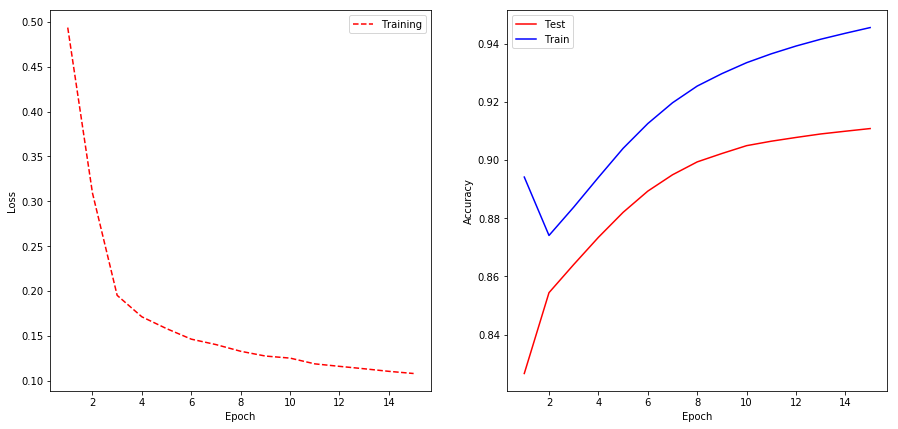

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Create count of the number of epochs
epoch_count = range(1, num_epochs + 1)

# Visualize loss history
ax1.plot(epoch_count, losses, 'r--', label='Training')
#ax1.plot(epoch_count, val_loss, 'b-', label='Validation')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(epoch_count, accuracies_test, 'r-', label='Test')
ax2.plot(epoch_count, accuracies_train, 'b-', label='Train')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
plt.show();

---

# Observe the recommendation results for our user

In [26]:
user_id = new_user_id
print(user_id)
movie_ids = [343, 862, 1124, 918, 438, 348, 447, 659, 875, 878]
print(movie_ids)

g = [0, 1, 1, 1, 0, 1, 0, 0, 0, 0]
print(g)
# = [1, 1, 0, 0, 1, 1]
# p is supposed to be the score of the class with greater label (if score is less than 0.5 with 1 decimal, then it predicted 0 otherwise it predicts 1)
p = predict(model, user_id, movie_ids)
print([1 if np.round(i)>0.5 else 0 for i in p])
print(roc_auc_score(g, p))

942
[343, 862, 1124, 918, 438, 348, 447, 659, 875, 878]
[0, 1, 1, 1, 0, 1, 0, 0, 0, 0]
[1, 1, 0, 1, 1, 1, 1, 1, 0, 0]
0.5


In [27]:
def predict_movies(model, user_id):
    movie_ids = list(df.iid.unique())
    prediction = predict(model, user_id, movie_ids)
    rated_high = [1 if np.round(i)>0.5 else 0 for i in prediction]
    good_movie_ids = np.where(np.array(rated_high) == 1)[0]  
    return list(good_movie_ids)



In [28]:
predicted_good_movies = predict_movies(model, user_id)

In [29]:
user_ratings = user_movie_ratings_training + user_movie_ratings_test
user_ratings_positive = []
user_ratings_negative = []
for ur in user_ratings:
    if ur[2] >= 4:
        user_ratings_positive.append(ur[1])
    else:
        user_ratings_negative.append(ur[1])

In [30]:
for m in user_ratings_positive:
    print(m if m in predicted_good_movies else f"{m} PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER")

891
488
141
612
862
1124 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
918
348


In [31]:
for m in user_ratings_negative:
    print(m if m not in predicted_good_movies else f"{m} PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER")

130 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
133 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
854 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
137 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
609 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
857 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
343 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
438 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
447 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
659 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
875
878


In [32]:
user_sparse_matrix = create_sparse_matrix(df_new_user_test)
acc = full_auc(model, user_sparse_matrix)
print(f"Accuracy for new user: {acc*100:.2f}%")

Accuracy for new user: 84.01%


Accuracy **93.1%** for this user is not bad, could be better! On the test set, accuracy on average is **90.9%**.

In [33]:
def predict_top_k_movies(model, user_id, k):
    n_users, n_movies = train.shape
    prediction = predict(model, user_id, np.arange(n_movies))
    movie_ids = df.iid.unique()
    return movie_ids[np.argsort(-prediction)][:k]

In [34]:
known_positives = df_train[(df_train.iid.isin(train.tocsr()[user_id].indices))&(df_train.uid==user_id)]["iid"]

k = 10
top_movies = predict_top_k_movies(model, user_id, k)

print("User %s" % user_id)
print("     Known positives:")
for x in known_positives[:k]:
    print(f"        {df[df.iid==x]['iid'].iloc[0]} | {df[df.iid==x]['title'].iloc[0]}" )
    
print("     Recommended:")
for x in top_movies:
    print(f"        {df[df.iid==x]['iid'].iloc[0]} | {df[df.iid==x]['title'].iloc[0]}" )

User 942
     Known positives:
        891 | good will hunting
        488 | air force one
        141 | murder at 1600
        612 | the game
     Recommended:
        488 | air force one
        137 | titanic
        486 | contact
        52 | the godfather
        17 | star wars
        130 | scream
        404 | the english patient
        0 | toy story
        133 | liar liar
        891 | good will hunting


---

# LightFM

Much faster implementation that is similar doing of the code implemented above.

In [35]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

In [36]:
def my2csr(df):
    return sp.csr_matrix(df.values)

In [37]:
train = create_sparse_matrix(df_train)#, mat_type="ratings")
test = create_sparse_matrix(df_test)#, mat_type="ratings")

# shape [n_users, n_user_features]
user_features = my2csr(df_users)
item_features = my2csr(df_movies)

In [38]:
use_features = False

loss_type = "warp"  # "bpr"

model = LightFM(learning_rate=0.05, loss=loss_type, max_sampled=100)

if use_features:
    model.fit_partial(train, epochs=20, user_features=user_features, item_features=item_features)
    #model.fit(train, epochs=50, user_features=user_features, item_features=item_features)
    train_precision = precision_at_k(model, train, k=10, user_features=user_features, item_features=item_features).mean()
    test_precision = precision_at_k(model, test, k=10, train_interactions=train, user_features=user_features, item_features=item_features).mean()

    train_auc = auc_score(model, train, user_features=user_features, item_features=item_features).mean()
    test_auc = auc_score(model, test, train_interactions=train, user_features=user_features, item_features=item_features).mean()

    print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
    print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))
else:
    model.fit_partial(train, epochs=20)
    
    train_precision = precision_at_k(model, train, k=10).mean()
    test_precision = precision_at_k(model, test, k=10).mean()

    train_auc = auc_score(model, train).mean()
    test_auc = auc_score(model, test, train_interactions=train).mean()

    print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
    print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))
    
    


Precision: train 0.50, test 0.09.
AUC: train 0.94, test 0.93.


In [39]:
user_ratings = user_movie_ratings_training + user_movie_ratings_test
user_ratings_positive = []
user_ratings_negative = []
for ur in user_ratings:
    if ur[2] >= 4:
        user_ratings_positive.append(ur[1])
    else:
        user_ratings_negative.append(ur[1])

In [40]:
def predict_movies(model, user_id):
    #movie_ids = list(_df.iid.unique())
    n_movies = train.shape[1]
    if use_features:
        prediction = model.predict(user_id, np.arange(n_movies), user_features=user_features, item_features=item_features)  #predict(model, user_id, movie_ids)
    else:
        prediction = model.predict(user_id, np.arange(n_movies))  #predict(model, user_id, movie_ids)
    
    rated_high = [1 if np.round(i)>0.5 else 0 for i in prediction]
    good_movie_ids = np.where(np.array(rated_high) == 1)[0]  
    return list(good_movie_ids)

In [41]:
predicted_good_movies = predict_movies(model, user_id)

In [42]:
for m in user_ratings_positive:
    print(m if m in predicted_good_movies else f"{m} PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER")

891
488
141
612
862 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
1124 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
918 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
348


In [43]:

for m in user_ratings_negative:
    print(m if m not in predicted_good_movies else f"{m} PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER")

130 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
133 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
854 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
137 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
609 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
857
343
438 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
447 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
659 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
875
878


In [45]:
user_sparse_matrix = create_sparse_matrix(df_new_user_test)
if use_features:
    acc = auc_score(model, user_sparse_matrix, user_features=user_features, item_features=item_features).mean()
else:
    acc = auc_score(model, user_sparse_matrix).mean()

print(f"Accuracy for new user: {acc*100:.2f}%")

Accuracy for new user: 88.54%


In [46]:
def predict_top_k_movies(model, user_id, k):
    n_users, n_movies = train.shape
    if use_features:
        prediction = model.predict(user_id, np.arange(n_movies), user_features=user_features, item_features=item_features)#predict(model, user_id, np.arange(n_movies))
    else:
        prediction = model.predict(user_id, np.arange(n_movies))#predict(model, user_id, np.arange(n_movies))
    
    movie_ids = np.arange(train.shape[1])
    return movie_ids[np.argsort(-prediction)][:k]

In [47]:
k = 10
user_id = new_user_id
movie_ids = np.arange(train.shape[1])

n_users, n_items = train.shape

known_positives = movie_ids[train.tocsr()[user_id].indices]

scores = model.predict(user_id, np.arange(n_items), user_features=user_features, item_features=item_features)
top_items = movie_ids[np.argsort(-scores)]

print("User %s" % user_id)
print("     Known positives:")

for x in known_positives[:k]:
    print(f"        {df[df.iid==x]['iid'].iloc[0]} | {df[df.iid==x]['title'].iloc[0]}" )
    
print("     Recommended:")
for x in top_items[:k]:
    print(f"        {df[df.iid==x]['iid'].iloc[0]} | {df[df.iid==x]['title'].iloc[0]}" )

User 942
     Known positives:
        141 | murder at 1600
        488 | air force one
        612 | the game
        891 | good will hunting
     Recommended:
        1279 | b. monkey
        1278 | sliding doors
        1277 | hush
        1276 | nightwatch
        1275 | hugo pool
        1273 | tainted
        1274 | entertaining angels: the dorothy day story
        1272 | the next step
        1271 | a brother's kiss
        1269 | twisted
